In [1]:
%matplotlib inline

In [2]:
import numpy as np
from astropy.io import fits
import os
import sys
import pdb
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from photutils.isophote import Ellipse
from photutils.isophote import EllipseGeometry
from photutils.aperture import EllipticalAperture

In [3]:
fits_files = ["17058_goodss_B_hudf.fits","17058_goodss_V_hudf.fits","17058_goodss_I_hudf.fits",
              "17058_goodss_Y_hudf.fits","17058_goodss_J_hudf.fits","17058_goodss_H_hudf.fits"]
zp = [25.673, 26.486, 25.654, 26.269, 26.230, 25.946]
pix_scale = [0.03, 0.03, 0.03, 0.06, 0.06, 0.03]
max_sb = [18, 18, 18, 18, 18, 18]
min_sb = [32, 32, 32, 32, 32, 32]
semimajor_axis = 60
position_angle = 90
axis_ratio = 0.7; ellip = 1 - axis_ratio
flag_check_images = False

In [4]:
# Create 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flatten axes for easy indexing
axes = axes.flatten()

# Loop over FITS files and display with imshow
for ii, (ax, filename) in enumerate(zip(axes, fits_files)):
    with fits.open(filename) as hdu:
        img = hdu[0].data
        hdr  = hdu[0].header

    img[img <= 0] = float("NaN")

    sb_img = -2.5*np.log10(img)+zp[ii]+(5*np.log10(pix_scale[ii]))
    if ii == 0 and flag_check_images == True: fits.writeto("test_B.fits", sb_img, hdr, overwrite=True)
                                         
    # Show image (auto contrast scaling with vmin/vmax as needed)
    img = ax.imshow(sb_img, cmap='viridis_r', origin='lower', vmin=max_sb[ii], vmax=min_sb[ii], interpolation="none")
    ax.set_title(f"{filename}")
    ax.axis('off')

# Adjust layout and show colorbar
plt.tight_layout()
plt.show()

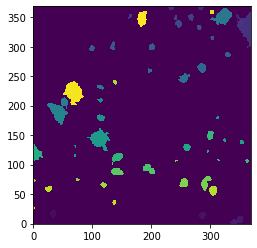

In [5]:
hdu = fits.open("segmentation_H.fits")
msk = hdu[0].data
hdr = hdu[0].header

msk[msk == 1] = 0
msk[msk == 24] = 0
msk[msk == 31] = 0

plt.imshow(msk, origin = "lower", interpolation ="none")

msk_zeros = msk == 0
msk_ones  = msk == 1
msk[msk_zeros] = 1
msk[msk_ones ] = 0
fits.writeto("mask_H_for_galfit.fits", msk, hdr, overwrite=True)

/tmp/ipykernel_1153690/4044468643.py:5: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img), origin='lower', interpolation="none", vmin=-4)


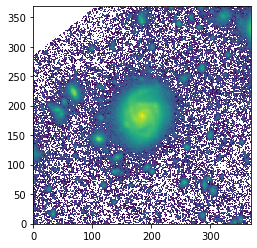

In [6]:
hdu = fits.open(fits_files[-1])
img = hdu[0].data
hdr = hdu[0].header

plt.imshow(np.log10(img), origin='lower', interpolation="none", vmin=-4)

In [7]:
x_cen = hdr["NAXIS1"]/2.
y_cen = hdr["NAXIS2"]/2.

geometry = EllipseGeometry(x0=x_cen, y0=y_cen, sma=semimajor_axis, eps=ellip, pa=position_angle * np.pi / 180.)
print(geometry.find_center(img),geometry.x0,geometry.y0)

INFO: Found center at x0 = 185.0, y0 = 183.0 [photutils.isophote.geometry]
None 185.0 183.0


/tmp/ipykernel_1153690/2465415380.py:4: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img), origin='lower', interpolation="none", vmin=-4)


(<matplotlib.patches.Ellipse at 0x7c917edd8710>,)

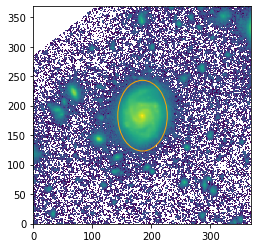

In [8]:
aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,
                          geometry.sma * (1 - geometry.eps),
                          geometry.pa)
plt.imshow(np.log10(img), origin='lower', interpolation="none", vmin=-4)
aper.plot(color='orange')

In [9]:
img = np.ma.array(img,mask=~msk)
ellipse = Ellipse(img, geometry)

In [10]:
isolist = ellipse.fit_image(nclip=3)

/home/fbuitrago/.local/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fbuitrago/.local/lib/python3.11/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/fbuitrago/.local/lib/python3.11/site-packages/numpy/_core/_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/fbuitrago/.local/lib/python3.11/site-packages/numpy/_core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/fbuitrago/.local/lib/python3.11/site-packages/numpy/_core/_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


IndexError: list index out of range

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplots_adjust(hspace=0.35, wspace=0.35)

plt.subplot(2, 2, 1)
plt.errorbar(isolist.sma, isolist.eps, yerr=isolist.ellip_err,
             fmt='o', markersize=4)
plt.ylim(-1,1)
plt.xlabel('Semimajor Axis Length (pix)')
plt.ylabel('Ellipticity')

plt.subplot(2, 2, 2)
plt.errorbar(isolist.sma, isolist.pa / np.pi * 180.,
             yerr=isolist.pa_err / np.pi * 80., fmt='o', markersize=4)
plt.ylim(-180,180)
plt.xlabel('Semimajor Axis Length (pix)')
plt.ylabel('PA (deg)')

plt.subplot(2, 2, 3)
plt.errorbar(isolist.sma, isolist.x0, yerr=isolist.x0_err, fmt='o',
             markersize=4)
plt.xlabel('Semimajor Axis Length (pix)')
plt.ylabel('x0')

plt.subplot(2, 2, 4)
plt.errorbar(isolist.sma, isolist.y0, yerr=isolist.y0_err, fmt='o',
             markersize=4)
plt.xlabel('Semimajor Axis Length (pix)')
plt.ylabel('y0')

In [ ]:
fig, ax = plt.subplots(figsize=(14, 5), nrows=1, ncols=1)
fig.subplots_adjust(left=0.04, right=0.98, bottom=0.02, top=0.98)
ax.imshow(np.log10(img), origin='lower', interpolation="none", vmin=-4)

smas = np.linspace(10, 100, 15)
for sma in smas:
    iso = isolist.get_closest(sma)
    x, y, = iso.sampled_coordinates()
    ax.plot(x, y, color='orange')